### BMI 203 - Final Project

#### Autoencoder

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from nn import nn
import numpy as np
import matplotlib.pyplot as plt

digits = load_digits()

X = digits.data
y = digits.target

In [2]:
from itertools import product

X_train, X_val = train_test_split(X, test_size=0.2, random_state=240)
X_train_scaled = X_train / 16.0  
X_val_scaled = X_val / 16.0

lrs = [1e-4, 5e-5, 1e-5]
batch_sizes = [64, 128, 256]
epochs_list = [2000, 3000, 5000]

best_model = None
best_error = float("inf")
best_params = {}
best_train_loss, best_val_loss = None, None

# looping over all combos to find best model
for lr, batch_size, epochs in product(lrs, batch_sizes, epochs_list):
    print(f"Testing lr={lr}, batch_size={batch_size}, epochs={epochs}...")

    # initm odel
    autoencoder = nn.NeuralNetwork(
        nn_arch=[
            {'input_dim': 64, 'output_dim': 32, 'activation': 'relu'},
            {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
            {'input_dim': 16, 'output_dim': 32, 'activation': 'relu'},
            {'input_dim': 32, 'output_dim': 64, 'activation': 'sigmoid'}
        ],
        lr=lr,
        seed=240,
        batch_size=batch_size,
        epochs=epochs,
        loss_function='mse'
    )

    # train
    train_loss, val_loss = autoencoder.fit(X_train_scaled, X_train_scaled, X_val_scaled, X_val_scaled)

    # compute error
    X_val_reconstructed = autoencoder.predict(X_val_scaled) * 16.0
    reconstruction_error = np.mean(np.square(X_val - X_val_reconstructed))

    print(f"Reconstruction Error: {reconstruction_error:.6f}")

    # track best model
    if reconstruction_error < best_error:
        best_error = reconstruction_error
        best_model = autoencoder
        best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}
        best_train_loss, best_val_loss = train_loss, val_loss

print("\nBest Model Found:")
print(f"LR: {best_params['lr']}, Batch Size: {best_params['batch_size']}, Epochs: {best_params['epochs']}")
print(f"Best Reconstruction Error: {best_error:.6f}")


Testing lr=0.0001, batch_size=64, epochs=2000...
Reconstruction Error: 18.690328
Testing lr=0.0001, batch_size=64, epochs=3000...
Reconstruction Error: 18.639629
Testing lr=0.0001, batch_size=64, epochs=5000...
Reconstruction Error: 18.449601
Testing lr=0.0001, batch_size=128, epochs=2000...
Reconstruction Error: 18.777089
Testing lr=0.0001, batch_size=128, epochs=3000...
Reconstruction Error: 18.716703
Testing lr=0.0001, batch_size=128, epochs=5000...
Reconstruction Error: 18.659658
Testing lr=0.0001, batch_size=256, epochs=2000...
Reconstruction Error: 19.251934
Testing lr=0.0001, batch_size=256, epochs=3000...
Reconstruction Error: 18.854483
Testing lr=0.0001, batch_size=256, epochs=5000...
Reconstruction Error: 18.739246
Testing lr=5e-05, batch_size=64, epochs=2000...
Reconstruction Error: 18.786113
Testing lr=5e-05, batch_size=64, epochs=3000...
Reconstruction Error: 18.721578
Testing lr=5e-05, batch_size=64, epochs=5000...
Reconstruction Error: 18.665042
Testing lr=5e-05, batch_s

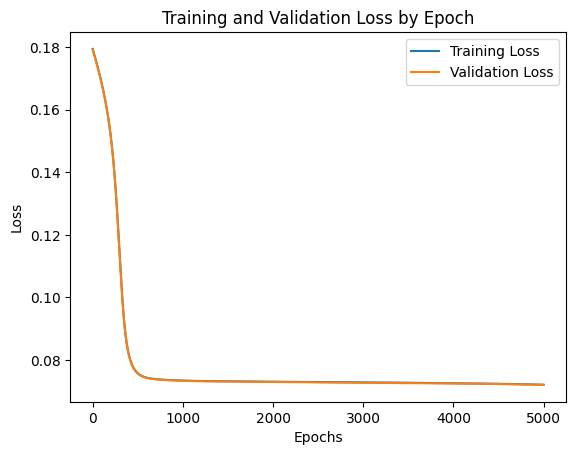

In [3]:
plt.plot(best_train_loss, label='Training Loss')
plt.plot(best_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Pred')

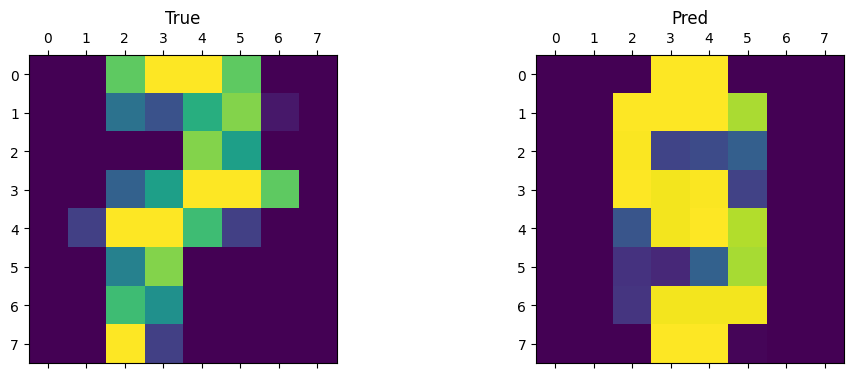

In [4]:
# reconstruct the validation set
X_val_reconstructed = best_model.predict(X_val) * 16.0

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].matshow(X_val[54].reshape((8, 8)))
ax[0].set_title("True")
ax[1].matshow(X_val_reconstructed[54].reshape((8, 8)))
ax[1].set_title("Pred")

#### Classifier

In [ ]:
from nn import io
direct = "data/"
p_seqs = io.read_text_file(direct + 'rap1-lieb-positives.txt')
n_seqs = io.read_fasta_file(direct + 'yeast-upstream-1k-negative.fa')

window_size = len(p_seqs[0])
processed_negatives = []

step = 50
for seq in n_seqs:
    for i in range(0, len(seq) - window_size + 1, step * window_size):
        processed_negatives.append(seq[i:i + window_size])

from nn import preprocess
balanced_seqs, balanced_labels = preprocess.sample_seqs(p_seqs + processed_negatives, [True] * len(p_seqs) + [False] * len(processed_negatives))
encoded_seqs = preprocess.one_hot_encode_seqs(balanced_seqs)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(encoded_seqs, balanced_labels, test_size=0.2, random_state=1729)
print("Training data size: ", X_train.shape[0])
print("Validation data size: ", X_val.shape[0])

Training data size:  10113
Validation data size:  2529


In [11]:
lrs = [1e-3, 5e-4, 1e-4]
batch_sizes = [32, 64, 128]
epochs_list = [300, 500, 1000]

best_model = None
best_acc = 0
best_params = {}
best_train_loss, best_val_loss = None, None

# looping over all combos to find best model
for lr, batch_size, epochs in product(lrs, batch_sizes, epochs_list):
    print(f"Testing lr={lr}, batch_size={batch_size}, epochs={epochs}...")

    # initm odel
    classifier = nn.NeuralNetwork(
        nn_arch=[
            {'input_dim': len(X_train[0]), 'output_dim': 64, 'activation': 'relu'},
            {'input_dim': 64, 'output_dim': 32, 'activation': 'relu'},
            {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
            {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}
        ],
        lr=lr,
        seed=240,
        batch_size=batch_size,
        epochs=epochs,
        loss_function='bce'
    )

    # train
    train_loss, val_loss = classifier.fit(X_train, np.array([[i] for i in y_train]), X_val, np.array([[i] for i in y_val]))

    # compute pred
    pred = (classifier.predict(X_val) >= 0.5).astype(int).T[0]
    acc = np.sum(pred == y_val) / len(y_val)

    print(f"Accuracy: {acc:.6f}")

    # track best model
    if acc > best_acc:
        best_acc = acc
        best_model = classifier
        best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}
        best_train_loss, best_val_loss = train_loss, val_loss

print("\nBest Model Found:")
print(f"LR: {best_params['lr']}, Batch Size: {best_params['batch_size']}, Epochs: {best_params['epochs']}")
print(f"Final accuracy on validation set: {best_acc:.6f}")


Testing lr=0.001, batch_size=32, epochs=300...
Accuracy: 0.986161
Testing lr=0.001, batch_size=32, epochs=500...
Accuracy: 0.984579
Testing lr=0.001, batch_size=32, epochs=1000...
Accuracy: 0.995255
Testing lr=0.001, batch_size=64, epochs=300...
Accuracy: 0.986951
Testing lr=0.001, batch_size=64, epochs=500...
Accuracy: 0.971135
Testing lr=0.001, batch_size=64, epochs=1000...
Accuracy: 0.993673
Testing lr=0.001, batch_size=128, epochs=300...
Accuracy: 0.970344
Testing lr=0.001, batch_size=128, epochs=500...
Accuracy: 0.977461
Testing lr=0.001, batch_size=128, epochs=1000...
Accuracy: 0.986556
Testing lr=0.0005, batch_size=32, epochs=300...
Accuracy: 0.967972
Testing lr=0.0005, batch_size=32, epochs=500...
Accuracy: 0.972716
Testing lr=0.0005, batch_size=32, epochs=1000...
Accuracy: 0.992487
Testing lr=0.0005, batch_size=64, epochs=300...
Accuracy: 0.971530
Testing lr=0.0005, batch_size=64, epochs=500...
Accuracy: 0.972716
Testing lr=0.0005, batch_size=64, epochs=1000...
Accuracy: 0.984

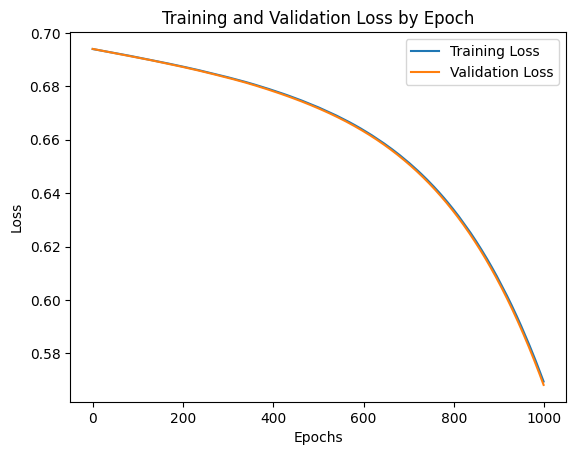

In [10]:
plt.plot(best_train_loss, label='Training Loss')
plt.plot(best_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.show()

The hyperparameter selection process was automated using a **grid search approach**, where different combinations of learning rate (`lr`), batch size (`batch_size`), and number of epochs (`epochs`) were systematically tested. The model was trained on each combination, and its performance was evaluated based on validation loss.  

The best hyperparameters were chosen based on the configuration that minimized the **validation loss** or maximized the **accuracy**, ensuring the model generalized well to unseen data. A balance was struck between **learning rate and batch size**—smaller `lr` values prevented unstable training, while moderate to larger batch sizes improved computational efficiency. The number of epochs was selected to ensure sufficient training without overfitting.  

This approach optimizes model performance by efficiently exploring hyperparameter space, allowing data-driven selection rather than manual tuning.